# Relative Transfer Function modeling for supervised source localization

A source is located in a reverberant enclosure and its speech is picked up by a microphone pair. The goal of the proposed algorithm is to localize the speaker from the measured microphone signals.

In [232]:
import pyroomacoustics as pra
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy

### Training stage

**Helper functions (move to script when done)**

In [190]:
def cartesian_to_spherical(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    phi = np.arctan(y/x)
    
    return r, theta, phi

def spherical_to_cartesian(r, theta, phi):
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)
    z = r*np.cos(theta)

    return x, y, z



def create_training(mic, m=481, azimuth=[math.pi/16, 2*math.pi/16], elevation=[7*math.pi/16, math.pi/2], radius = 1):
    '''
    This function generates m training samples located on a sector of a sphere around the first microphone. This sphere has a fixed radius of 1 m
    '''
    training_Set_xyz = []
    training_Set_spherical = []
    epsilon = 1e-7
    for i in range(m):
        azimuth_i = np.random.uniform(low=azimuth[0], high=azimuth[1]+epsilon)
        elevation_i = np.random.uniform(low=elevation[0], high=elevation[1]+epsilon)
        pos_xyz_i = mic + spherical_to_cartesian(radius, elevation_i, azimuth_i)
        training_Set_xyz.append(pos_xyz_i)
        training_Set_spherical.append((radius, elevation_i, azimuth_i))
    return training_Set_xyz, training_Set_spherical


def create_perturbations(training_Set_sph, mic, L=20):
    '''
    This function generates the L different perturbations around the source position
    '''
    nb_src = len(training_Set_sph)
    postions_Of_perturbations = []
    
    for src_pos in training_Set_sph:
        for i in range(L):
            perturbations_i = np.random.randn(2)
            pos_xyz_perturb_i = mic + spherical_to_cartesian(src_pos[0], src_pos[1] + perturbations_i[0], src_pos[2] + perturbations_i[1])
            postions_Of_perturbations.append(pos_xyz_perturb_i)
        
    return postions_Of_perturbations



def feature_Vector_src(index_src, D=256):
    '''
    This function creates the feature vector for given source/perturbation position using the microphones in the room
    '''
    rir0 = room.rir[0][index_src]
    rir1 = room.rir[1][index_src]
    len0, len1 = rir0.shape[0], rir1.shape[0]

    atf_0 = pra.stft(rir0, L=D, hop=len0)
    atf_1 = pra.stft(rir1, L=D, hop=len1)
    
    return atf_0 / atf_1

def feature_Vector_perturb(index_perturb, D=256):
    '''
    This function creates the feature vector for given source/perturbation position using the microphones in the room
    '''
    rir0 = room_perturb.rir[0][index_perturb]
    rir1 = room_perturb.rir[1][index_perturb]
    len0, len1 = rir0.shape[0], rir1.shape[0]

    atf_0 = pra.stft(rir0, L=D, hop=len0)
    atf_1 = pra.stft(rir1, L=D, hop=len1)
    
    return atf_0 / atf_1


def covMatrix_from_perturb(feature_vecs_set, L=20, D=256):
    
    cov = np.zeros((D,D), dtype='complex128')
    for feat_vec in feature_vecs_set:
        cov += feat_vec * feat_vec.T
    
    return cov/L

def index_cov_matrix(index_k, index_l, training_positions):
    if index_k == index_l:
        return index_k
    else:
        pos_k, pos_l = training_positions[index_k], training_positions[index_l]
        pos_middle = 0.5*(pos_k + pos_l)
        current_dist_min = np.linalg.norm(pos_middle - pos_k)
        index_min = index_k
        for i,pos in enumerate(training_positions):
            dist = np.linalg.norm(pos_middle - pos)
            if dist < current_dist_min:
                current_dist_min = dist
                index_min = i
        return index_min
    

    
def normalizing_factor(index_k, index_l, training_positions, cov_matrices):
    index = index_cov_matrix(index_k, index_l, training_positions)
    return np.sqrt(np.linalg.det(cov_matrices[index]))


def compute_elem_W_kl(index_k, index_l, cov_matrices, epsilon = 1e20):
    #How to choose epsilon ?
    feature_vec_k, feature_vec_l = feature_Vector_src(index_k), feature_Vector_src(index_l)
    inv_cov_sum = np.linalg.inv(cov_matrices[index_k] + cov_matrices[index_l])
    
    nom = (feature_vec_k - feature_vec_l) @ inv_cov_sum @ (feature_vec_k - feature_vec_l).T
    d_kl = 1 # to fix
    
    return (np.pi/d_kl) * np.exp(-nom/epsilon)


def compute_affinity_matrix(cov_matrices, m=481):
    W = np.zeros((m, m), dtype='complex128')
    for k in range(m):
        for l in range(m):
            W[k, l] = compute_elem_W_kl(k, l, cov_matrices)
            
    return W

def compute_feature_Vecs_set(src_index, L=20):
    '''
    This function compute the feature vectors of the perturbations around the source with index `src_index`
    '''
    feature_vec_set = []
    for i,_ in enumerate(postions_Of_perturbations[src_index:L+src_index]):
        index_perturb = src_index*L + i
        feature_vec_set.append(feature_Vector_perturb(index_perturb))
    return feature_vec_set

def compute_covMatrices(m=481):
    '''
    This function computes the covariance matrices of the sources in the training set
    '''
    cov_matrices = []
    for src_index in range(m):
        feature_vecs_set = compute_feature_Vecs_set(src_index)
        cov_matrices.append(covMatrix_from_perturb(feature_vecs_set))
    
    return cov_matrices

**Define some constants**

In [322]:
fs = 8000 # sampling frequencey
m = 481 # number of sources in training stage
M = 480 # number of sources in test stage
L = 20 # number of perturbations around a given source 

**Create sources positions and their respective perturbated positions**

In [208]:
# Add 2 microphones
mics = np.array([[3, 1, 1], [3.2, 1, 1]])
mic_array = pra.MicrophoneArray(mics.T, fs)
mic0_pos = mic_array.R[:,0]
mic1_pos = mic_array.R[:,1]

training_Set_xyz, training_Set_spherical = create_training(mic0_pos)
postions_Of_perturbations = create_perturbations(training_Set_spherical, mic0_pos)

**Create room where training sources are added**

In [249]:
# Create a 6.5 by 3.5  by 2 metres shoe box room
room = pra.ShoeBox([6.5, 3.5, 2], fs=fs, max_order=3)

room.add_microphone_array(mic_array)

# Add wgn of 3 seconds duration 
duration_samples = 3*int(fs) 

for pos in training_Set_xyz:
    source_signal = np.random.randn(duration_samples)
    room.add_source(pos, signal=source_signal)

room.image_source_model(use_libroom=False)
room.compute_rir()

**Create room where perturbations are added**

In [159]:
# Create the exact same room, where we wil add only the perturbed postions 
room_perturb = pra.ShoeBox([6.5, 3.5, 2], fs=fs, max_order=3)
room_perturb.add_microphone_array(mic_array)

# Add wgn of 3 seconds duration 
duration_samples = 3*int(fs) 

for pos in postions_Of_perturbations:
    source_signal = np.random.randn(duration_samples)
    room_perturb.add_source(pos, signal=source_signal)
    
room_perturb.image_source_model(use_libroom=False)
room_perturb.compute_rir()

**Visualize setup**

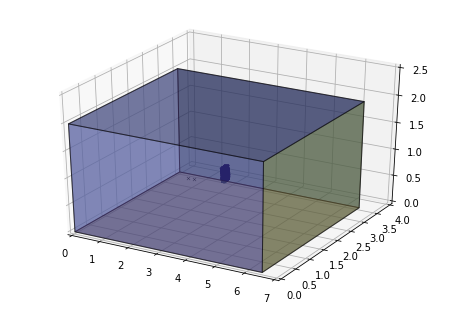

In [113]:
fig, ax = room.plot()
ax.set_xlim([0, 7])
ax.set_ylim([0, 4])
ax.set_zlim([0, 2.5]);

**Compute _*affinity matrix*_ W **

In [320]:
cov_matrices = compute_covMatrices()
W = compute_affinity_matrix(cov_matrices)
eig_vals, eig_vects = np.linalg.eig(W)

Remark : *the column `eig_vects[:,i]` is the eigenvector corresponding to the eigenvalue `eig_vals[i]`*

### Test stage

**Create room where test source positions are added**

In [ ]:
# Create the exact same room, where we wil add only the test positions 
room_test = pra.ShoeBox([6.5, 3.5, 2], fs=fs, max_order=3)
room_test.add_microphone_array(mic_array)

# Add wgn of 3 seconds duration 
duration_samples = 3*int(fs) 

eig_vals, eig_vects = np.linalg.eig(W)

for pos in 'postions_Of_perturbations':
    source_signal = np.random.randn(duration_samples)
    room_test.add_source(pos, signal=source_signal)
    
room_test.image_source_model(use_libroom=False)
room_test.compute_rir()